In [1]:
import joblib

In [7]:
# 📌 Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# 📌 Cargar el dataset
df = pd.read_csv('cleaned_clasified_Dota2_chats.csv')

# 📌 Mostrar primeras filas para verificar datos
print(df.head())

# 📌 Filtrar columnas necesarias
df = df[['text_en', 'predicted_label']]


    match        time  slot                  text_en predicted_label
0  954334   -26.06113     7                fist item    coordination
1  756982    85.44562     9                 new meta    coordination
2  925441  2173.20525     5        weve got kerry gg        chitchat
3  946663  1507.19866     6         fuck its a point   toxic_offense
4  244781  1298.58290     0  dont be so nervous lion    coordination


In [8]:
# 📌 Convertir texto en características numéricas con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limitar a 5000 características para no sobrecargar memoria
X_tfidf = vectorizer.fit_transform(df['text_en'])

# 📌 Convertir etiquetas a formato numérico
y = df['predicted_label']

print("TF-IDF vectorización completada. Forma de los datos:", X_tfidf.shape)


TF-IDF vectorización completada. Forma de los datos: (73576, 5000)


In [9]:
# 📌 Aplicar SMOTE para aumentar la cantidad de datos en clases minoritarias
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

print("✅ SMOTE aplicado. Nueva distribución de clases:")
print(pd.Series(y_resampled).value_counts())


✅ SMOTE aplicado. Nueva distribución de clases:
predicted_label
coordination             29865
chitchat                 29865
toxic_offense            29865
gender_discrimination    29865
racism                   29865
religious_intolerance    29865
Name: count, dtype: int64


In [10]:
# 📌 Dividir en datos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape[0]} muestras")
print(f"Datos de prueba: {X_test.shape[0]} muestras")



Datos de entrenamiento: 143352 muestras
Datos de prueba: 35838 muestras


In [11]:
# 📌 Definir el modelo base de Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# 📌 Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [100, 300],       # Número de árboles en el bosque
    'max_depth': [10, 30],            # Profundidad máxima del árbol
    'min_samples_split': [2, 5],      # Min muestras para dividir un nodo
    'min_samples_leaf': [1, 2],       # Min muestras en una hoja
    'max_features': ['sqrt', 'log2']  # Número de features en cada división
}

print("Parámetros listos para GridSearchCV.")


Parámetros listos para GridSearchCV.


In [12]:
# 📌 Optimización con GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 📌 Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("✅ Mejores hiperparámetros encontrados:", best_params)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ Mejores hiperparámetros encontrados: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [13]:
# 📌 Entrenar el modelo final con los mejores hiperparámetros
rf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

print("✅ Modelo entrenado con los mejores hiperparámetros.")


✅ Modelo entrenado con los mejores hiperparámetros.


In [14]:
# 📌 Predicciones en el conjunto de prueba
y_pred = rf_best.predict(X_test)

# 📌 Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print("\n🔹 Accuracy del modelo optimizado:", accuracy)
print("\n📌 Reporte de Clasificación:\n", classification_report(y_test, y_pred))



🔹 Accuracy del modelo optimizado: 0.797868184608516

📌 Reporte de Clasificación:
                        precision    recall  f1-score   support

             chitchat       0.91      0.67      0.77      5972
         coordination       0.69      0.70      0.69      5956
gender_discrimination       0.93      0.93      0.93      5973
               racism       0.65      0.92      0.76      5985
religious_intolerance       0.87      0.85      0.86      5983
        toxic_offense       0.85      0.71      0.77      5969

             accuracy                           0.80     35838
            macro avg       0.81      0.80      0.80     35838
         weighted avg       0.81      0.80      0.80     35838



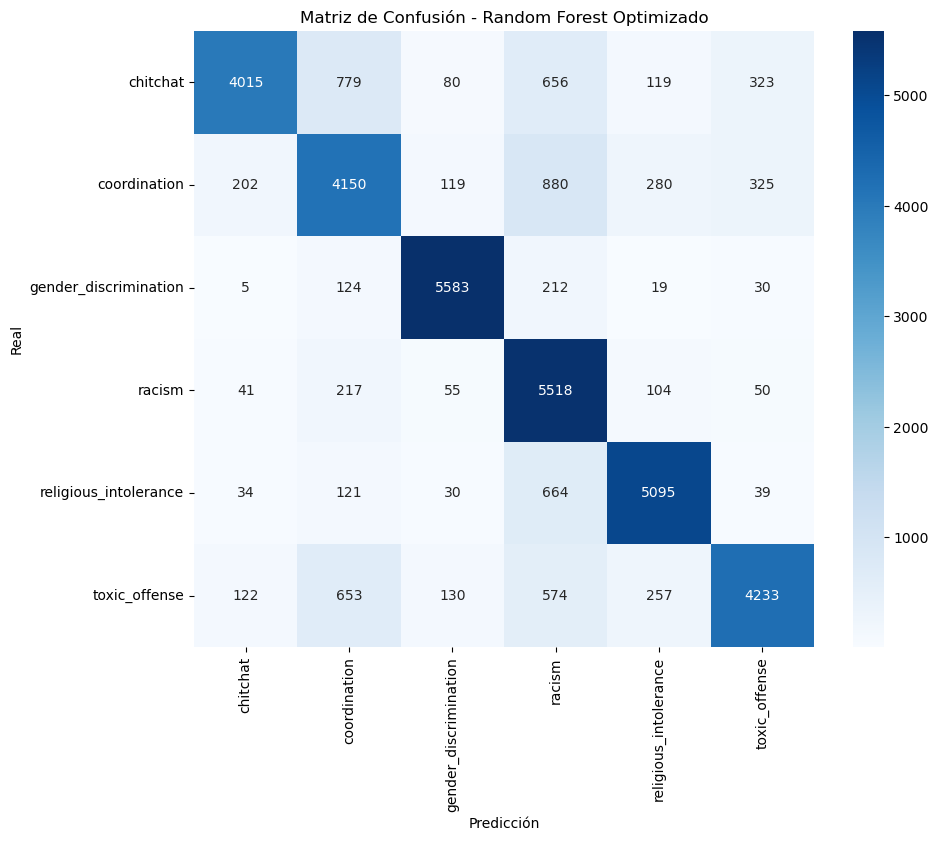

In [15]:
# 📌 Matriz de Confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.show()


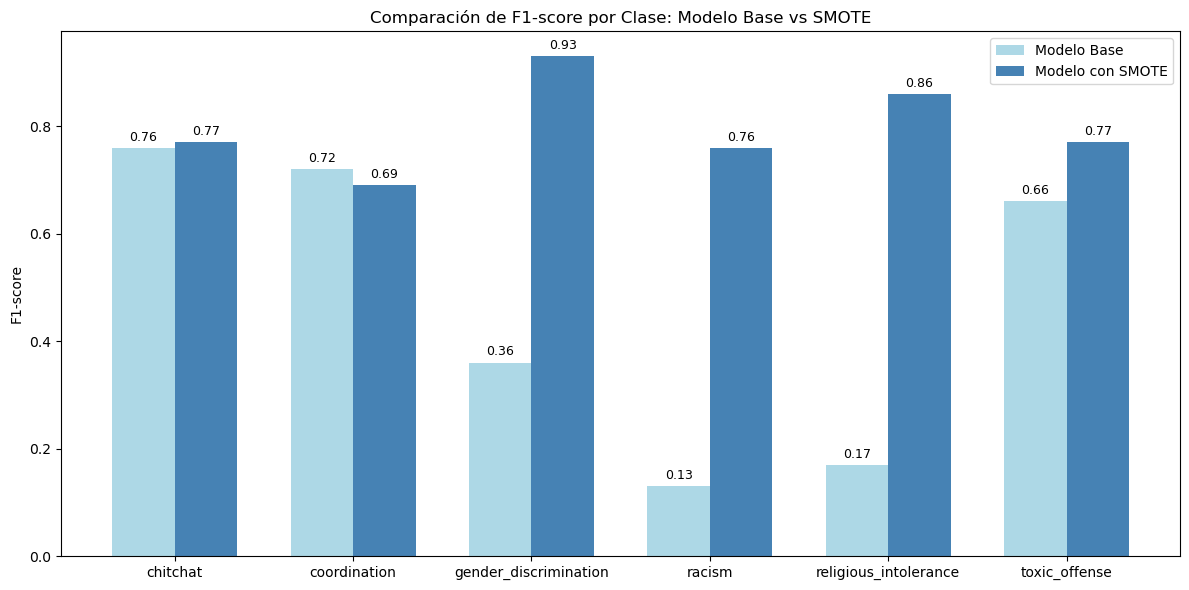

In [16]:
''''
recomedaciones tras tutoria.
Comparacion de F1-score por clase: Modelo Base vs SMOTE

'''
import matplotlib.pyplot as plt
import numpy as np

# Nombres de las clases
classes = ['chitchat', 'coordination', 'gender_discrimination', 
           'racism', 'religious_intolerance', 'toxic_offense']

# F1-scores antes de aplicar SMOTE (modelo base)
f1_base = [0.76, 0.72, 0.36, 0.13, 0.17, 0.66]

# F1-scores después de aplicar SMOTE (modelo optimizado)
f1_smote = [0.77, 0.69, 0.93, 0.76, 0.86, 0.77]

# Posición de las barras
x = np.arange(len(classes))
width = 0.35  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, f1_base, width, label='Modelo Base', color='lightblue')
bars2 = ax.bar(x + width/2, f1_smote, width, label='Modelo con SMOTE', color='steelblue')

# Etiquetas y título
ax.set_ylabel('F1-score')
ax.set_title('Comparación de F1-score por Clase: Modelo Base vs SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Mostrar valores sobre las barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3), 
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()


In [17]:
import joblib

# Guardar el modelo entrenado (Random Forest optimizado)
joblib.dump(rf_best, "modelo.pkl")

# Guardar el vectorizador TF-IDF
joblib.dump(vectorizer, "vectorizador.pkl")

print("✅ Modelo y vectorizador guardados correctamente.")


✅ Modelo y vectorizador guardados correctamente.
